<a href="https://colab.research.google.com/github/chitra-psg/nlp_ticket_classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser','ner'])
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import swifter
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file
drive.mount('/content/drive')

file_path = open('/content/drive/MyDrive/nlp/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(file_path)
df_sourcedata = pd.json_normalize(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.

df_sourcedata.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#Lets view the schema of the dataframe
df_sourcedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names

# Print the column names
def print_column_names():
    i = 1
    for col in df_sourcedata.columns:
        print(str("{:02d}".format(i)) +" Column:\033[1m", col, '\033[0m')
        i += 1

print_column_names()

01 Column: _index 
02 Column: _type 
03 Column: _id 
04 Column: _score 
05 Column: _source.tags 
06 Column: _source.zip_code 
07 Column: _source.complaint_id 
08 Column: _source.issue 
09 Column: _source.date_received 
10 Column: _source.state 
11 Column: _source.consumer_disputed 
12 Column: _source.product 
13 Column: _source.company_response 
14 Column: _source.company 
15 Column: _source.submitted_via 
16 Column: _source.date_sent_to_company 
17 Column: _source.company_public_response 
18 Column: _source.sub_product 
19 Column: _source.timely 
20 Column: _source.complaint_what_happened 
21 Column: _source.sub_issue 
22 Column: _source.consumer_consent_provided 


In [7]:
#Lets removenthe prefix _ and also source.
#Assign new column names
new_columns = {}
for col in df_sourcedata.columns:
    new_columns[col] = re.sub("^_", "", col).replace("source.", "")

df_sourcedata.rename(columns = new_columns, inplace = True)

print_column_names()

01 Column: index 
02 Column: type 
03 Column: id 
04 Column: score 
05 Column: tags 
06 Column: zip_code 
07 Column: complaint_id 
08 Column: issue 
09 Column: date_received 
10 Column: state 
11 Column: consumer_disputed 
12 Column: product 
13 Column: company_response 
14 Column: company 
15 Column: submitted_via 
16 Column: date_sent_to_company 
17 Column: company_public_response 
18 Column: sub_product 
19 Column: timely 
20 Column: complaint_what_happened 
21 Column: sub_issue 
22 Column: consumer_consent_provided 


In [8]:
# Get the shape and size of the dataset
print('No of rows:\033[1m', df_sourcedata.shape[0], '\033[0m')
print('No of cols:\033[1m', df_sourcedata.shape[1], '\033[0m')

No of rows: 78313 
No of cols: 22 


In [9]:
# Check % of NULLs in each column
(df_sourcedata.isnull().sum()/ len(df_sourcedata)) * 100

index                         0.000000
type                          0.000000
id                            0.000000
score                         0.000000
tags                         86.081493
zip_code                      8.628197
complaint_id                  0.000000
issue                         0.000000
date_received                 0.000000
state                         2.542362
consumer_disputed             0.000000
product                       0.000000
company_response              0.000000
company                       0.000000
submitted_via                 0.000000
date_sent_to_company          0.000000
company_public_response      99.994892
sub_product                  13.498397
timely                        0.000000
complaint_what_happened       0.000000
sub_issue                    59.117899
consumer_consent_provided     1.287143
dtype: float64

In [10]:
#Assign nan in place of blanks in the complaints column
#df_sourcedata['complaint_what_happened'].unique()
len(df_sourcedata[df_sourcedata['complaint_what_happened'] == ''])

57241

In [11]:
#Remove all rows where complaints column is nan
df_data = df_sourcedata[df_sourcedata['complaint_what_happened'] != '']
print('Remaining Rows:\033[1m', len(df_data), '\033[0m')

Remaining Rows: 21072 


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_data(text):
    text = text.lower() # text to lowercase
    text = re.sub(r'\s\{\$\S*', '',text) # Remove text within curly braces
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'\(\w*\)', '', text) #remove text within braces
    text = re.sub(r'(\W\s)|(\W$)|(\W\d*)', ' ',text) # Remove punctuation
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    text = re.sub(r' +', ' ',text) #Remove unnecessary white spaces
    return text

In [13]:
#Write your function to Lemmatize the texts
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str


In [14]:
pip install swifter

In [15]:
import nltk
nltk.download('punkt')

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

df_clean = pd.DataFrame({'complaint_what_happened':df_data['complaint_what_happened'], 'lemmatized':df_data['complaint_what_happened'].apply(lemmatization)})

In [17]:
df_clean

,complaint_what_happened,lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX..."
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...
...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I called Chas , my X..."
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yr . I 've h...


In [18]:
#Write your function to extract the POS tags
def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son chase account fund chase bank account mone...
...,...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I called Chas , my X...",xxxx xxxx provider claim purchase protection b...
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer bank app year banking m...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yr . I 've h...,credit credit card problem balance transfer li...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




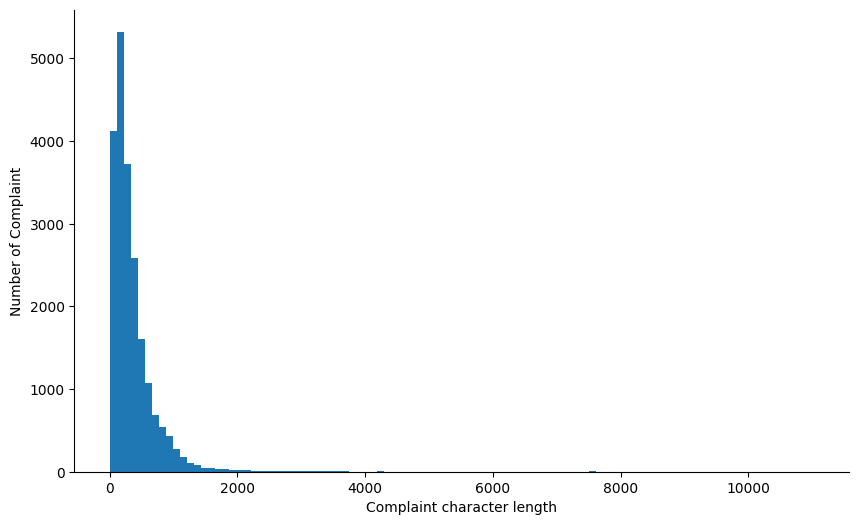

In [20]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

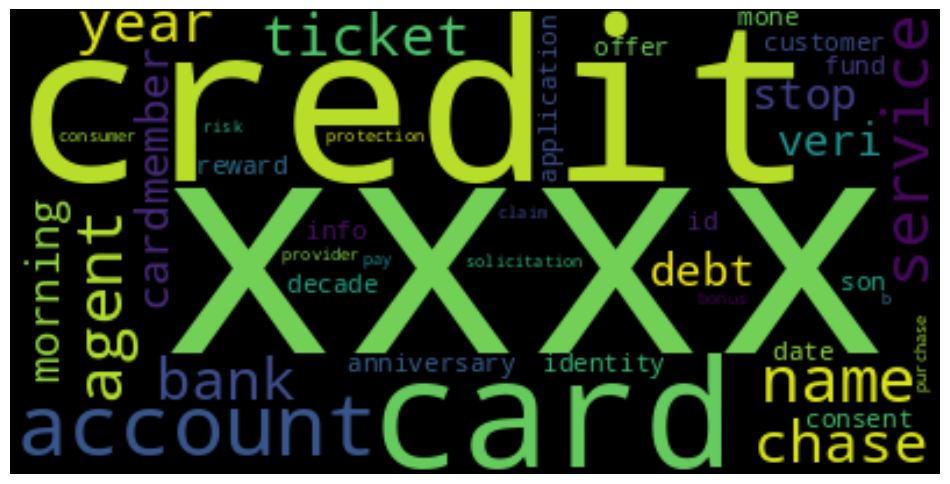

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Top 40 words frequency wise wordcloud
wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

,complaint_what_happened,lemmatized,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...,morning name stop cardmember service debt veri...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...,xxxx xxxx card agent anniversary date agent in...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xxxx xxxx ticket offer ticket reward card info...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...,customer decade solicitation credit card bonus...,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I called Chas , my X...",xxxx xxxx provider claim purchase protection b...,xxxx xxxx provider claim purchase protection b...
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer bank app year banking m...,xxxx pay risk consumer bank app year banking m...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yr . I 've h...,credit credit card problem balance transfer li...,credit credit card problem balance transfer li...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [23]:
def top_grams(grams):
    c_vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(grams,grams))
    grams = c_vec.fit_transform(df_clean['complaint_what_happened'])
    count_values = grams.toarray().sum(axis=0)
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram

In [33]:
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def generate_ngrams(text, n):
    # Tokenize the input text into words
    words = word_tokenize(text)

    # Create n-grams using NLTK's ngrams function
    n_grams = list(ngrams(words, n))

    return n_grams

# Example usage:
input_text = "This is a sample sentence for n-gram generation."
n = 3 # Change n to generate different n-grams (1 for unigram, 2 for bigram, 3 for trigram, etc.)

result = generate_ngrams(input_text, n)
print(result)


[('This', 'is', 'a'), ('is', 'a', 'sample'), ('a', 'sample', 'sentence'), ('sample', 'sentence', 'for'), ('sentence', 'for', 'n-gram'), ('for', 'n-gram', 'generation'), ('n-gram', 'generation', '.')]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
df_unigram = top_grams(1)
df_unigram.head(30)

,frequency,unigram
0,228998,xxxx
1,80810,chase
2,77015,xx
3,42745,account
4,32806,credit
5,30482,00
6,26941,card
7,26760,bank
8,20364,would
9,16383,told


In [26]:
df_unigram_top10 = df_unigram.head(10)
df_unigram_top10

,frequency,unigram
0,228998,xxxx
1,80810,chase
2,77015,xx
3,42745,account
4,32806,credit
5,30482,00
6,26941,card
7,26760,bank
8,20364,would
9,16383,told


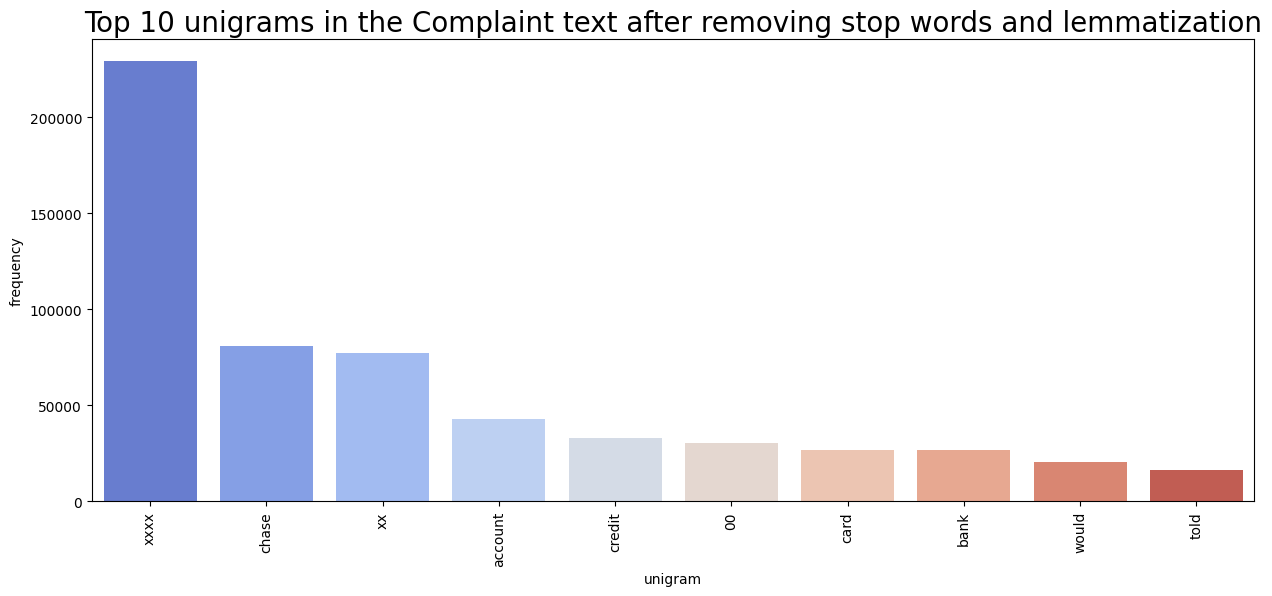

In [27]:
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='frequency', data=df_unigram_top10, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [28]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
df_bigram = top_grams(2)
df_bigram.head(30)

,frequency,unigram
0,89040,xxxx xxxx
1,38191,xx xx
2,28157,xx xxxx
3,12708,chase bank
4,10938,credit card
5,5786,xxxx xx
6,4835,xxxx chase
7,3659,called chase
8,3568,checking account
9,3246,credit report


In [29]:
df_bigram_top10 = df_bigram.head(10)
df_bigram_top10

,frequency,unigram
0,89040,xxxx xxxx
1,38191,xx xx
2,28157,xx xxxx
3,12708,chase bank
4,10938,credit card
5,5786,xxxx xx
6,4835,xxxx chase
7,3659,called chase
8,3568,checking account
9,3246,credit report


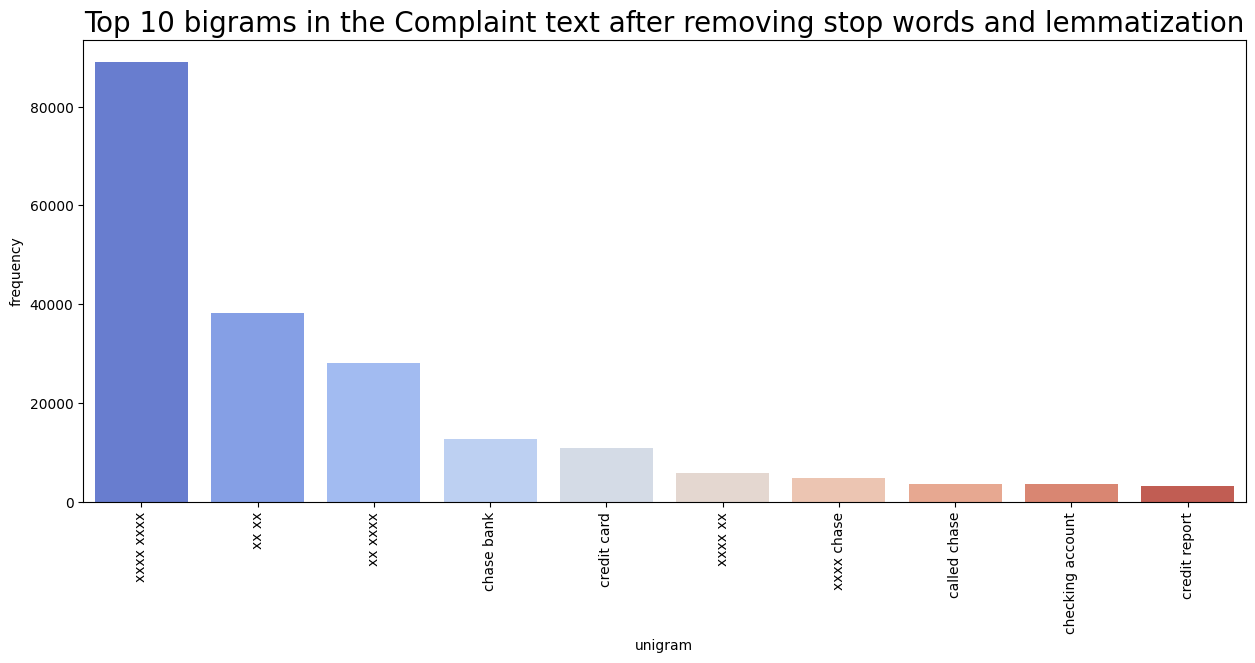

In [30]:
#Print the top 10 words in the bigram frequency
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='frequency', data=df_bigram_top10, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 10 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [1]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
df_trigram = top_grams(3)
#df_trigram.head(30)

NameError: ignored

In [ ]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [79]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [80]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...,morning name stop cardmember service debt veri...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,xxxx xxxx card agent anniversary date agent in...,card agent anniversary date agent informatio...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card wa reported on XX/XX/2019 . However...,application identity consent service credit id...,application identity consent service credit id...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/2018 , while trying to book a XXXX XX...",xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for { $ 1600.00 } i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,After being a Chase Card customer for well ove...,customer decade solicitation credit card bonus...,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I called Chas , my X...",xxxx xxxx provider claim purchase protection b...,provider claim purchase protection benefit s...
78310,I am not familiar with XXXX pay and did not un...,I am not familiar with XXXX pay and did not un...,xxxx pay risk consumer bank app year banking m...,pay risk consumer bank app year banking merch...
78311,I have had flawless credit for 30 yrs. I've ha...,I have had flawless credit for 30 yr . I 've h...,credit credit card problem balance transfer li...,credit credit card problem balance transfer li...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



